In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
import torch.optim as optim
from torch.utils.data import sampler
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import os

### Data Loading

In [2]:
# https://github.com/sonu275981/GTSRB---German-Traffic-Sign-Recognition/blob/main/GTSRB%20-%20German%20Traffic%20Sign%20Recognition%20Benchmark.ipynb

In [3]:
from PIL import Image
cur_path = "./gtsrb-german-traffic-sign"

In [4]:
model_name = "dataaug_mcdnn_16" 
model_name = model_name + ".pt"
output_dir = "./outputs"

In [5]:
transform = transforms.Compose([
    transforms.RandomRotation(degrees=10), 
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor() 
])

In [6]:
data = []
data_transformed = []
labels = []
classes = 43

#Retrieving the images and their labels 
for i in range(classes):
    path = os.path.join(cur_path,'Train',str(i))
    images = os.listdir(path)

    for a in images:
        image = Image.open(os.path.join(path, a))
        image = image.resize((48,48))
        # image = np.array(image)
        image_transformed = transform(image)
        data_transformed.append([image_transformed, i])
        data.append([image,i])


In [7]:
x = []
y = []

for features,label in data_transformed:
    x.append(features)
    y.append(label)

In [8]:
#Converting lists into numpy arrays
x = np.array(x)
y = np.array(y)
y = np.reshape(y, (-1, 1))

In [9]:
print(x.shape)
print(y.shape)

(39209, 3, 48, 48)
(39209, 1)


In [10]:
# x = np.swapaxes(x, 1, 3)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
X_train = X_train/255.0
X_val = X_val/255.0

In [12]:
print("Shape of train images is:", X_train.shape)
print("Shape of labels is:", y_train.shape)

Shape of train images is: (31367, 3, 48, 48)
Shape of labels is: (31367, 1)


In [13]:
X_train_tensor = torch.Tensor(X_train) 
X_val_tensor = torch.Tensor(X_val)
y_train_tensor = torch.LongTensor(y_train) 
y_val_tensor = torch.LongTensor(y_val)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor) 
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Running Model

In [14]:
#Use this if you are running on any Cuda enabled system
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps'
print(device)

mps


In [15]:
# TODO
input_dim = 48*48
batch_size = 128
n_epochs = 16
num_classes = 43

In [16]:
class MCDNN(nn.Module):
    def __init__(self):
        super(MCDNN, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=7),
            nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(100, 150, kernel_size=4),
            nn.BatchNorm2d(150),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(150, 250, kernel_size=4),
            nn.BatchNorm2d(250),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(250*3*3, 300)
        self.fc2 = nn.Linear(300, 43)
        
        nn.init.uniform_(self.fc1.weight, a=-0.05, b=0.05)
        nn.init.uniform_(self.fc1.bias, a=-0.05, b=0.05)
        nn.init.uniform_(self.fc2.weight, a=-0.05, b=0.05)
        nn.init.uniform_(self.fc2.bias, a=-0.05, b=0.05)

        # nn.init.xavier_uniform_(self.fc1.weight)
        # nn.init.constant_(self.fc1.bias, 0.0)
        # nn.init.xavier_uniform_(self.fc2.weight)
        # nn.init.constant_(self.fc2.bias, 0.0)

    def forward(self,x):
        x = self.network(x)
        x = x.view(-1, 250*3*3)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
# notes from TA:

# # Resnet
# # bigger neural network
# # VGG

# existing architectures to try
# torchvision

# train on less classes


# depends on th assumption
# - tehnically it works, but not real work defencce against the attacks

# ensemble models
# take average of gradients

# and then perturb on that gradient



In [17]:
from torchsummary import summary
mcdnn = MCDNN()#.to(device)
summary(mcdnn,(3,48,48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 100, 42, 42]          14,800
       BatchNorm2d-2          [-1, 100, 42, 42]             200
              ReLU-3          [-1, 100, 42, 42]               0
         MaxPool2d-4          [-1, 100, 21, 21]               0
            Conv2d-5          [-1, 150, 18, 18]         240,150
       BatchNorm2d-6          [-1, 150, 18, 18]             300
              ReLU-7          [-1, 150, 18, 18]               0
         MaxPool2d-8            [-1, 150, 9, 9]               0
            Conv2d-9            [-1, 250, 6, 6]         600,250
      BatchNorm2d-10            [-1, 250, 6, 6]             500
             ReLU-11            [-1, 250, 6, 6]               0
        MaxPool2d-12            [-1, 250, 3, 3]               0
          Flatten-13                 [-1, 2250]               0
           Linear-14                  [

In [18]:
mcdnn = MCDNN().to(device)

In [19]:
criterion = torch.nn.CrossEntropyLoss() # TODO: specify loss function
optimizer =  torch.optim.Adam(params=mcdnn.parameters(), lr=0.001)

In [21]:
#mcdnn.compile()
train_losses = []
val_losses = []
for epoch in range(n_epochs):
  mcdnn.train()
  train_loss = 0
  val_loss = 0
  loss = None
  for batch_idx, (data, labels) in enumerate(train_loader):
      #TODO
      data = data.to(device)
      optimizer.zero_grad()
      output = mcdnn.forward(data)
      labels = torch.nn.functional.one_hot(labels, num_classes=43)
      labels = torch.squeeze(labels, dim=1).float().to(device)
      
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss
  train_loss = train_loss/len(train_loader)
  train_losses.append(train_loss)
  
  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = torch.nn.functional.one_hot(labels, num_classes=43)
      labels = torch.squeeze(labels, dim=1).float().to(device)
      valout = mcdnn.forward(inputs)
      loss = criterion(valout, labels)
      val_loss += loss.item()
    val_loss = val_loss/len(val_loader)
    val_losses.append(val_loss)
  
  print(f"Epoch: {epoch+1} \tTraining Loss: {train_loss} \tVal Loss: {val_loss}")

Epoch: 1 	Training Loss: 0.822980523109436 	Val Loss: 0.48034037938041074
Epoch: 2 	Training Loss: 0.26765361428260803 	Val Loss: 0.29971049846180026
Epoch: 3 	Training Loss: 0.15234415233135223 	Val Loss: 0.17057689447556773
Epoch: 4 	Training Loss: 0.09673724323511124 	Val Loss: 0.16611891540308152
Epoch: 5 	Training Loss: 0.07138842344284058 	Val Loss: 0.1732258323820368
Epoch: 6 	Training Loss: 0.08118696510791779 	Val Loss: 0.13578744304756965
Epoch: 7 	Training Loss: 0.047339946031570435 	Val Loss: 0.10675330610284882
Epoch: 8 	Training Loss: 0.02847283147275448 	Val Loss: 0.10034076154472367
Epoch: 9 	Training Loss: 0.06901049613952637 	Val Loss: 0.16411236541405802
Epoch: 10 	Training Loss: 0.043988510966300964 	Val Loss: 0.11756441997544419
Epoch: 11 	Training Loss: 0.02822628617286682 	Val Loss: 0.10558989444266885
Epoch: 12 	Training Loss: 0.03126874566078186 	Val Loss: 0.1597325739961478
Epoch: 13 	Training Loss: 0.056916579604148865 	Val Loss: 0.09397490728165835
Epoch: 14

##Plotting

In [22]:
train_losses = [t.cpu().detach().numpy() for t in train_losses]

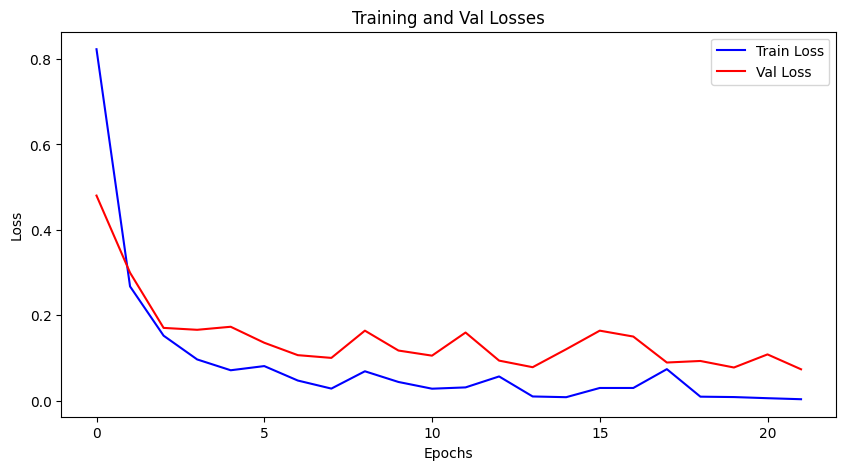

In [23]:
## Plot the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Val Losses')
plt.legend()
plt.show()

## Save Model

In [24]:
torch.save(mcdnn.state_dict(), os.path.join(output_dir, model_name))

## Running Inference

In [25]:
import csv

In [26]:
data = []
data_transformed = []
labels = []
classes = 43

In [27]:
path = os.path.join(cur_path,'Test')
images = os.listdir(path)

for a in images:
    image = Image.open(os.path.join(path, a))
    image = image.resize((48,48))
    data.append(image)

In [28]:
# Open the CSV file for reading
with open(os.path.join(cur_path,'Test.csv'), newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        # Assuming the element you want to append is the first element in each row
        labels.append([torch.tensor(int(row[6]))])

In [29]:
print(len(labels))

12630


In [30]:
x = np.array(data)
y = np.array(labels)
y = np.reshape(y, (-1, 1))
x = np.swapaxes(x, 1, 3)

print(x.shape)
print(y.shape)

(12630, 3, 48, 48)
(12630, 1)


In [31]:
X_test = x/255.0

X_test = torch.Tensor(X_test) 
y_test_tensor = torch.LongTensor(y) 

print(X_test.shape)
print(y_test_tensor.shape)
test_dataset = TensorDataset(X_test, y_test_tensor)

batch_size = 128
test_dataloader = DataLoader(test_dataset, shuffle=False)

torch.Size([12630, 3, 48, 48])
torch.Size([12630, 1])


In [37]:
model = MCDNN().to(device)
model.load_state_dict(torch.load(os.path.join(output_dir, model_name)))
model.eval()

MCDNN(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(100, 150, kernel_size=(4, 4), stride=(1, 1))
    (5): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(150, 250, kernel_size=(4, 4), stride=(1, 1))
    (9): BatchNorm2d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2250, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=43, bias=True)
)

In [32]:
# mcdnn.eval()

MCDNN(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(100, 150, kernel_size=(4, 4), stride=(1, 1))
    (5): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(150, 250, kernel_size=(4, 4), stride=(1, 1))
    (9): BatchNorm2d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2250, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=43, bias=True)
)

In [38]:
test_loss = 0
test_correct = 0
for inputs, labels in test_dataloader:
    inputs = inputs.to(device)
    nlabels = torch.nn.functional.one_hot(labels, num_classes=43)
    nlabels = torch.squeeze(nlabels, dim=1).float().to(device)
    
    test_out = model.forward(inputs)
    loss = criterion(test_out, nlabels)
    numoutput = torch.argmax(test_out, dim=1)
    
    # inputs = torch.squeeze(inputs, dim=0)
    # image_array= inputs.permute(1, 2, 0).cpu().numpy()
    
    # plt.imshow(image_array)
    # plt.axis('off')  # Hide axes
    # plt.show()
    # print(numoutput)
    # print(labels)
    
    labels = labels.view(-1).to(device)
    #print(f"Label is:{labels} and predicted is: {numoutput}")
    test_correct = test_correct + 1 if labels == numoutput else test_correct + 0
    test_loss += loss.item()
    


In [39]:
print(len(test_dataloader))

12630


In [40]:
test_loss = test_loss/len(test_dataloader)
test_correct = test_correct/len(test_dataloader)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_correct * 100}")

Test Loss: 1600.9520140737743
Test Accuracy: 3.8163103721298497
